In [1]:
%matplotlib inline
import os
import math as m
import time
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pre_process_functions import *
from PIL import Image
import numpy as np


## Definite the pre processing functions

In [2]:

def gen_doplet_v5(sigma,volume0,rneedle=0.5):
    # when output=1 gSD return r_a,z_a
    r_a,z_a=genSingleDrop(sigma=sigma,volume0=volume0,rneedle=rneedle,output=1)
    wmax=2*max(abs(r_a))

    # use plt generate synthetic image and save as arrayd
    plt.fill_between(r_a,z_a,color='black')
    plt.fill_between(-r_a,z_a,color='black')
    plt.axis('equal')
    plt.axis('off')

    figure = plt.gcf().canvas
    ag = figure.switch_backends(FigureCanvasAgg)
    ag.draw()
    plt.close()
    A = np.asarray(ag.buffer_rgba())
    syn_array = np.rint(A[...,:3] @ [0.2126, 0.7152, 0.0722]).astype(np.uint8)
    

    return syn_array,wmax,rneedle

def crop_margin_array_v5(syn_array):#(DONE)
        
        (row,col)=syn_array.shape
        img=syn_array

        for i in range(row-1):
                if sum(img[i])!=255*col:
                        cut1=i
                        break               

        for i in range(row-1,0,-1):
                if sum(img[i])!=255*col:
                        cut2=i
                        break 

        _,img1,_=np.split(img,[cut1,cut2])  

        for i in range(col-1):
                if sum(img[:,i])!=255*row:
                        cut3=i
                        break

        for i in range(col-1,0,-1):
                if sum(img[:,i])!=255*row:
                        cut4=i
                        break

        _,cm_arr,_=np.split(img1,[cut3,cut4],axis=1)

        return cm_arr

def resize_syn_arr(syn_arr_cm,wmax,r_syn=1):
    syn_img = Image.fromarray(syn_arr_cm)
    w,h=syn_img.size
    r_syn=1
    w_n=wmax/(2*r_syn)*50
    scaling=w_n/w
    h_n=scaling*h
    new_syn=syn_img.resize((int(w_n),int(h_n)))
    syn_arr_rs=np.asarray(new_syn)

    return syn_arr_rs

def remove_needle_centering_v5(img_ori):#(Need Test)
    '''img_ori=Image.open(path_ori)'''
    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to width 300

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    for j in range(needle.shape[0]-1):
        j=j+1
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                end=end+1
    #print(stopline)

    addpad=right_edge[stopline]-needle[stopline]/2-w_ori2/2

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
    
    h_won,w_won=img_WON.shape
    
    # centering
    if addpad>0:
        img_won=np.hstack( ( img_WON,np.ones((h_won,abs(int(addpad*4))))*255 ) )
    elif addpad<0:
        img_won=np.hstack( ( np.ones((h_won,abs(int(addpad*4))))*255,img_WON ) )
    else:
        img_won=img_WON

    return img_won,needle

def cost_v3(img_ori,img_syn,width=100,output=0):
    '''
    input:              
    x:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    output: 0 -->lost, 1-->C, else C,lost
    '''
    img_syn = Image.fromarray(img_syn)
    img_ori = Image.fromarray(img_ori)

    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(abs((w_syn2-w_ori2)/2))

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    droplet=0
    for i in range(w_ori2):
        for j in range (h_ori2):
            if A[i,j]==255:
                droplet=droplet+1

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    #lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    
    lost=f/droplet
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

## Definite the obtimize funciton

In [3]:
def obtimize_v5(sv,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),output=0):
    '''need initialize xs and losts if output==0'''
    start = time.time()
    sigma=sv[0]
    v0=sv[1]

    # preprosessing the ori image
    ori,needle=remove_needle_centering_v5(Image.open(path_ori))
    pixel_needle=needle[0]

    # gen and post processing the syn image
    syn_arr,wmax,rneedle=gen_doplet_v5(sigma=sigma,volume0=v0,rneedle=0.5)

    #crop the margin of syn image
    syn_arr_cm=crop_margin_array_v5(syn_arr)
    syn=resize_syn_arr(syn_arr_cm,wmax,r_syn=1)

    end = time.time()
    #print('Obtimize Program execution time: ',end - start)

    if output==0:
        lost=cost_v3(ori,syn,output=output)
        return lost
    elif output==1:
        C=cost_v3(ori,syn,output=output)
        return C
    else :
        C,lost=cost_v3(ori,syn,output=output)
        return C, lost


## Start the optimization

In [ ]:
import scipy.optimize
# use scipy obtimaize the parameter
opStart=time.time()
print('Optimization Start')
xs=[]
losts=[]
x0=np.asarray((75,11))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
res=scipy.optimize.minimize(obtimize_v5,x0,method='nelder-mead',options={'maxiter':50})
opEnd=time.time()
print('Optimize Program Running Time: ',opEnd-opStart)

In [ ]:
print(res)

In [ ]:
# save all varables
import dill
filename='./optimization results.pkl'
dill.dump_session(filename)

In [ ]:
import dill
dill.load_session( './optimization results.pkl')

## Plot the Trace Image

In [ ]:
arxs=np.asarray(xs)
plt.plot(arxs[:,0],arxs[:,1])

In [ ]:
x=arxs[:,0]
y=arxs[:,1]
z=losts

fig,ax=plt.subplots()
cs=ax.contourf(x,y,z,cmap=plt.get_camp('Spectal'))

cbar=fig.colorbar(cs)
plt.show

In [ ]:
x=np.asarray((73,16))
C,lost=obtimize_v5(sv=x,output=2)
Image.fromarray(np.uint8(C))

## Draw the Local Grid

In [ ]:
import dill
dill.load_session( './optimization results.pkl')

print(res)

In [ ]:
arxs=np.asarray(xs)
sigmas=arxs[:,0]
volumes=arxs[:,1]

s0=min(sigmas)-(max(sigmas)-min(sigmas))*0.05
s1=max(sigmas)+(max(sigmas)-min(sigmas))*0.05

v0=min(volumes)-(max(volumes)-min(volumes))*0.05
v1=max(volumes)+(max(volumes)-min(volumes))*0.05



## Draw the Global Grid

In [4]:
from tqdm import tqdm
import time

In [7]:
import numpy as np
Grid=[]

v1=1
v2=20

print('Calculate lost of sigma[20,30) & volume[1,20)')
for i in tqdm(range(20,30,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))

print('Calculate lost of sigma[30,40) & volume[1,20)')
for i in tqdm(range(30,40,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))

print('Calculate lost of sigma[40,50) & volume[1,20)')
for i in tqdm(range(40,50,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))

print('Calculate lost of sigma[50,60) & volume[1,20)')
for i in tqdm(range(50,60,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))

print('Calculate lost of sigma[60,70) & volume[1,20)')
for i in tqdm(range(60,70,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))

print('Calculate lost of sigma[70,80) & volume[1,20)')
for i in tqdm(range(70,80,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))

print('Calculate lost of sigma[80,90) & volume[1,20)')
for i in tqdm(range(80,90,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))
        
print('Calculate lost of sigma[90,100) & volume[1,20)')
for i in tqdm(range(90,100,2)):
    for j in range (v1,v2,2):
        lost=obtimize_v5(sv=np.asarray((i,j)),output=0)
        Grid.append(np.asarray((i,j,lost)))


Calculate lost of sigma[20,30) & volume[1,20)


100%|██████████| 5/5 [03:13<00:00, 38.71s/it] 


Calculate lost of sigma[30,40) & volume[1,20)


100%|██████████| 5/5 [01:22<00:00, 16.52s/it]


Calculate lost of sigma[40,50) & volume[1,20)


100%|██████████| 5/5 [01:17<00:00, 15.54s/it]


Calculate lost of sigma[50,60) & volume[1,20)


100%|██████████| 5/5 [01:25<00:00, 17.11s/it]


Calculate lost of sigma[60,70) & volume[1,20)


100%|██████████| 5/5 [01:37<00:00, 19.49s/it]


Calculate lost of sigma[70,80) & volume[1,20)


100%|██████████| 5/5 [01:53<00:00, 22.79s/it]


Calculate lost of sigma[80,90) & volume[1,20)


100%|██████████| 5/5 [01:54<00:00, 22.81s/it]


Calculate lost of sigma[90,100) & volume[1,20)


100%|██████████| 5/5 [01:40<00:00, 20.19s/it]


In [37]:
grid_arr=np.asarray(Grid)
sigma= np.asarray(range(20,100,2))
volume=np.asarray(range (1,20,2))
lost=grid_arr[:,2]


In [38]:
sigma

array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52,
       54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86,
       88, 90, 92, 94, 96, 98])

In [39]:
grid_arr[10:20]


array([[22.        ,  1.        ,  0.41462443],
       [22.        ,  3.        ,  0.32058179],
       [22.        ,  5.        ,  0.22454672],
       [22.        ,  7.        ,  0.41462443],
       [22.        ,  9.        ,  0.14624427],
       [22.        , 11.        ,  0.32396892],
       [22.        , 13.        ,  0.27176728],
       [22.        , 15.        ,  0.65650528],
       [22.        , 17.        ,  0.58916119],
       [22.        , 19.        ,  0.56066946]])

In [41]:
lost2d=np.reshape(lost,(40,10))
lost2d

array([[0.41462443, 0.30942419, 0.21737398, 0.41462443, 0.4670253 ,
        0.43793584, 0.41462443, 0.49193066, 0.42717673, 0.41462443],
       [0.41462443, 0.32058179, 0.22454672, 0.41462443, 0.14624427,
        0.32396892, 0.27176728, 0.65650528, 0.58916119, 0.56066946],
       [0.26100817, 0.25622634, 0.23331341, 0.15700339, 0.42279339,
        0.41462443, 0.50986252, 0.3972903 , 0.46881849, 0.50966328],
       [0.30962343, 0.27953776, 0.23391114, 0.16118749, 0.52241482,
        0.31241283, 0.39191074, 0.39330544, 0.4516836 , 0.64016736],
       [0.45228133, 0.26479378, 0.23948994, 0.1733413 , 0.22713688,
        0.41462443, 0.41462443, 0.41462443, 0.4237896 , 0.41462443],
       [0.34847579, 0.24706117, 0.24606495, 0.16895796, 0.60669456,
        0.59493923, 0.43275553, 0.36401674, 0.40386531, 0.5329747 ],
       [0.23948994, 0.25343694, 0.24885435, 0.17931859, 0.11038055,
        0.46124726, 0.36142658, 0.41462443, 0.4502889 , 0.37278342],
       [0.28989839, 0.2476589 , 0.2568240

In [45]:
import dill
dill.dump_session( './GlobalGrid.pkl')


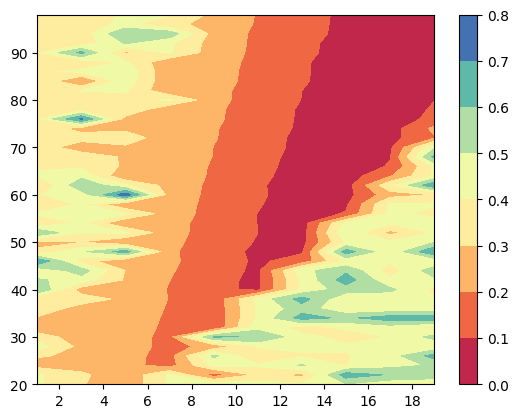

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm
#进行绘图
fig, ax = plt.subplots()
cs = ax.contourf(volume,sigma, lost2d, cmap=plt.get_cmap('Spectral'))
#添加colorbar
cbar = fig.colorbar(cs)
plt.show()